In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
!unzip /content/drive/MyDrive/dogs-vs-cats.zip

Archive:  /content/drive/MyDrive/dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [ ]:
!unzip /content/train.zip
!unzip /content/test1.zip

Streaming output truncated to the last 5000 lines.
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           

In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
TRAIN_DIR = "/content/train"
TEST_DIR = "/content/test1"

TOTAL_TRAIN_SIZE = 1000
VALID_SIZE = 500
TEST_SIZE = 500

BATCH_SIZE = 100
EPOCHS = 50

IMAGE_WIDTH = IMAGE_HEIGHT = 150

# creating df with train labels
train_filenames = os.listdir(TRAIN_DIR)
train_labels = [filename.split('.')[0] for filename in train_filenames]

train_df = pd.DataFrame({
    'id': train_filenames,
    'label': train_labels
})

# Shuffle the DataFrame
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into train, validation, and test sets
train_set = train_df[:TOTAL_TRAIN_SIZE]
remaining_set = train_df[TOTAL_TRAIN_SIZE:]

valid_set = remaining_set[:VALID_SIZE]
test_set = remaining_set[VALID_SIZE:VALID_SIZE+TEST_SIZE]

# augmentation settings, for now just normalizing
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255.,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# not doing any data augmentation on validation and test set
valid_test_datagen = ImageDataGenerator(rescale=1./255.)

# creating train, validation, and test generators
train_generator = train_datagen.flow_from_dataframe(
    train_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    valid_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_generator = valid_test_datagen.flow_from_dataframe(
    test_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 1000 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


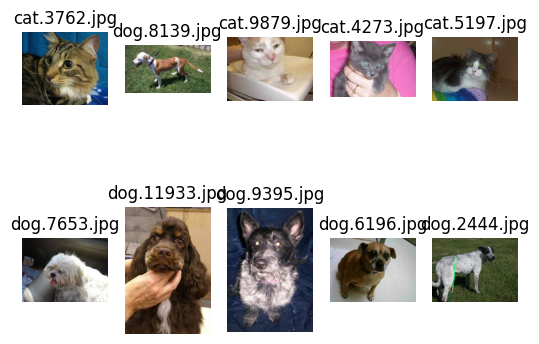

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define paths
output_train_folder = '/content/train'

# Function to display images
def display_images(folder, num_images=10):
    # Get list of image files
    image_files = [f for f in os.listdir(folder) if f.endswith('.jpg')]

    # Display the first num_images images
    for i, image_file in enumerate(image_files[:num_images]):
        image_path = os.path.join(folder, image_file)
        img = mpimg.imread(image_path)
        plt.subplot(2, 5, i+1)  # Adjust subplot layout for 10 images
        plt.imshow(img)
        plt.title(image_file)
        plt.axis('off')
    plt.show()

# Display 10 images from the training data folder
display_images(output_train_folder, num_images=10)


In [ ]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [ ]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [ ]:
history = model.fit_generator(train_generator,
                              validation_data=valid_generator,
                              steps_per_epoch=len(train_generator),
                              validation_steps=len(valid_generator),
                              epochs=EPOCHS,
                              verbose=1)

<ipython-input-9-c516ba2fb733>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/50
10/10 [==============================] - 17s 878ms/step - loss: 0.7724 - acc: 0.5140 - val_loss: 0.6927 - val_acc: 0.5300
Epoch 2/50
10/10 [==============================] - 7s 718ms/step - loss: 0.6937 - acc: 0.5180 - val_loss: 0.6927 - val_acc: 0.5140
Epoch 3/50
10/10 [==============================] - 10s 985ms/step - loss: 0.6925 - acc: 0.5160 - val_loss: 0.6920 - val_acc: 0.4960
Epoch 4/50
10/10 [==============================] - 8s 784ms/step - loss: 0.6952 - acc: 0.5170 - val_loss: 0.6921 - val_acc: 0.5640
Epoch 5/50
10/10 [==============================] - 10s 939ms/step - loss: 0.6933 - acc: 0.5180 - val_loss: 0.6917 - val_acc: 0.5880
Epoch 6/50
10/10 [==============================] - 11s 1s/step - loss: 0.6903 - acc: 0.5410 - val_loss: 0.6903 - val_acc: 0.5360
Epoch 7/50
10/10 [==============================] - 9s 910ms/step - loss: 0.6971 - acc: 0.5180 - val_loss: 0.6907 - val_acc: 0.5320
Epoch 8/50
10/10 [==============================] - 8s 763ms/step - loss: 0

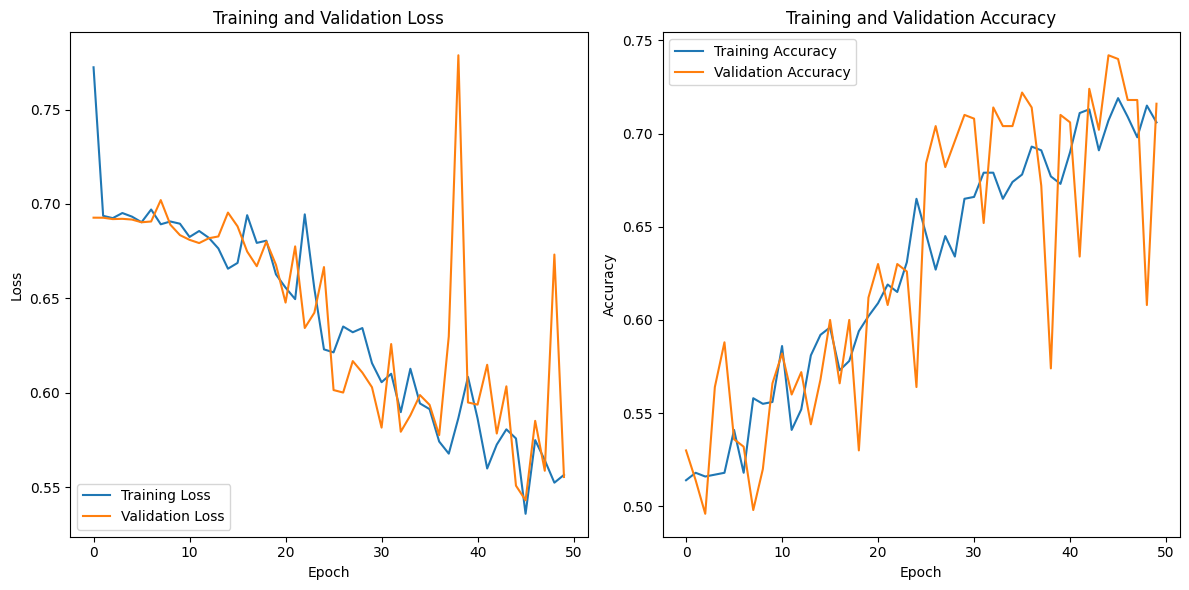

In [ ]:
import matplotlib.pyplot as plt

# Extract the training and validation loss and accuracy from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate the model on the test data
evaluation = model.evaluate(test_generator)

# Print the evaluation results
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

5/5 [==============================] - 1s 198ms/step - loss: 0.5542 - acc: 0.6980
Test Loss: 0.5542147159576416
Test Accuracy: 0.6980000138282776


In [ ]:
# Augmentation settings for training data
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255.,  # Normalization
    brightness_range=[0.5, 1.5],  # Random brightness adjustment
    channel_shift_range=20,  # Random channel shifts
    vertical_flip=True  # Randomly flip inputs vertically
)# creating train, validation, and test generators
train_generator = train_datagen.flow_from_dataframe(
    train_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)
valid_generator = train_datagen.flow_from_dataframe(
    valid_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_generator = train_datagen.flow_from_dataframe(
    test_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 1000 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


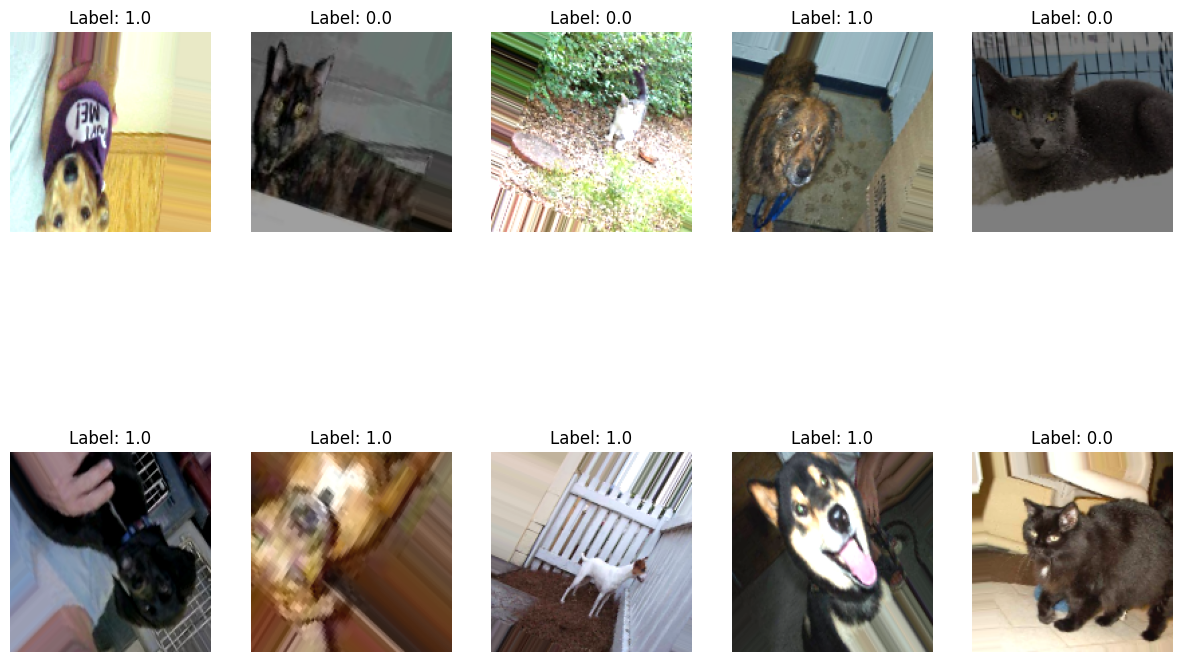

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of 10 images and labels from the training generator
images, labels = next(train_generator)

# Display the images and labels
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title('Label: {}'.format(labels[i]))
    plt.axis('off')
plt.show()

In [ ]:
history = model.fit_generator(train_generator,
                              validation_data=valid_generator,
                              steps_per_epoch=len(train_generator),
                              validation_steps=len(valid_generator),
                              epochs=EPOCHS,
                              verbose=1)

<ipython-input-14-c516ba2fb733>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/50
10/10 [==============================] - 14s 1s/step - loss: 0.6110 - acc: 0.6550 - val_loss: 0.6135 - val_acc: 0.6480
Epoch 2/50
10/10 [==============================] - 15s 2s/step - loss: 0.6116 - acc: 0.6640 - val_loss: 0.6069 - val_acc: 0.6900
Epoch 3/50
10/10 [==============================] - 18s 2s/step - loss: 0.6080 - acc: 0.6560 - val_loss: 0.6263 - val_acc: 0.6600
Epoch 4/50
10/10 [==============================] - 13s 1s/step - loss: 0.6174 - acc: 0.6610 - val_loss: 0.6198 - val_acc: 0.6440
Epoch 5/50
10/10 [==============================] - 13s 1s/step - loss: 0.6133 - acc: 0.6600 - val_loss: 0.6118 - val_acc: 0.6740
Epoch 6/50
10/10 [==============================] - 15s 2s/step - loss: 0.6074 - acc: 0.6750 - val_loss: 0.6108 - val_acc: 0.6680
Epoch 7/50
10/10 [==============================] - 18s 2s/step - loss: 0.6332 - acc: 0.6570 - val_loss: 0.6196 - val_acc: 0.6860
Epoch 8/50
10/10 [==============================] - 12s 1s/step - loss: 0.6041 - acc: 0.68

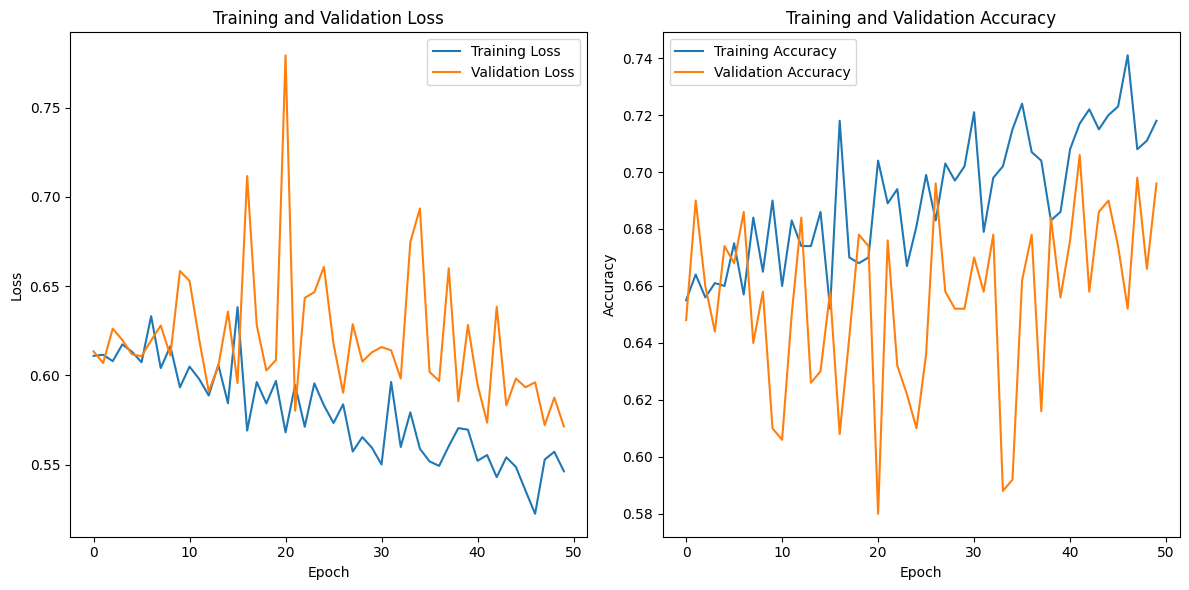

In [ ]:
import matplotlib.pyplot as plt

# Extract the training and validation loss and accuracy from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate the model on the test data
evaluation = model.evaluate(test_generator)

# Print the evaluation results
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

5/5 [==============================] - 4s 924ms/step - loss: 0.5811 - acc: 0.6960
Test Loss: 0.5810728073120117
Test Accuracy: 0.6959999799728394


In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
TRAIN_DIR = "/content/train"
TEST_DIR = "/content/test1"

TOTAL_TRAIN_SIZE = 3000
VALID_SIZE = 500
TEST_SIZE = 500

BATCH_SIZE = 100
EPOCHS = 50

IMAGE_WIDTH = IMAGE_HEIGHT = 150

# creating df with train labels
train_filenames = os.listdir(TRAIN_DIR)
train_labels = [filename.split('.')[0] for filename in train_filenames]

train_df = pd.DataFrame({
    'id': train_filenames,
    'label': train_labels
})

# Shuffle the DataFrame
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into train, validation, and test sets
train_set = train_df[:TOTAL_TRAIN_SIZE]
remaining_set = train_df[TOTAL_TRAIN_SIZE:]

valid_set = remaining_set[:VALID_SIZE]
test_set = remaining_set[VALID_SIZE:VALID_SIZE+TEST_SIZE]

# augmentation settings, for now just normalizing
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255.,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# not doing any data augmentation on validation and test set
valid_test_datagen = ImageDataGenerator(rescale=1./255.)

# creating train, validation, and test generators
train_generator = train_datagen.flow_from_dataframe(
    train_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    valid_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_generator = valid_test_datagen.flow_from_dataframe(
    test_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 3000 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [ ]:
history = model.fit_generator(train_generator,
                              validation_data=valid_generator,
                              steps_per_epoch=len(train_generator),
                              validation_steps=len(valid_generator),
                              epochs=EPOCHS,
                              verbose=1)

<ipython-input-18-c516ba2fb733>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/50
30/30 [==============================] - 27s 876ms/step - loss: 0.5617 - acc: 0.7090 - val_loss: 0.5390 - val_acc: 0.7500
Epoch 2/50
30/30 [==============================] - 24s 811ms/step - loss: 0.5424 - acc: 0.7220 - val_loss: 0.5200 - val_acc: 0.7560
Epoch 3/50
30/30 [==============================] - 24s 809ms/step - loss: 0.5221 - acc: 0.7330 - val_loss: 0.5511 - val_acc: 0.7160
Epoch 4/50
30/30 [==============================] - 24s 818ms/step - loss: 0.5574 - acc: 0.7123 - val_loss: 0.5400 - val_acc: 0.7400
Epoch 5/50
30/30 [==============================] - 26s 862ms/step - loss: 0.5166 - acc: 0.7360 - val_loss: 0.5674 - val_acc: 0.6760
Epoch 6/50
30/30 [==============================] - 26s 864ms/step - loss: 0.5131 - acc: 0.7427 - val_loss: 0.5901 - val_acc: 0.7160
Epoch 7/50
30/30 [==============================] - 25s 828ms/step - loss: 0.5173 - acc: 0.7437 - val_loss: 0.4939 - val_acc: 0.7680
Epoch 8/50
30/30 [==============================] - 24s 806ms/step - 

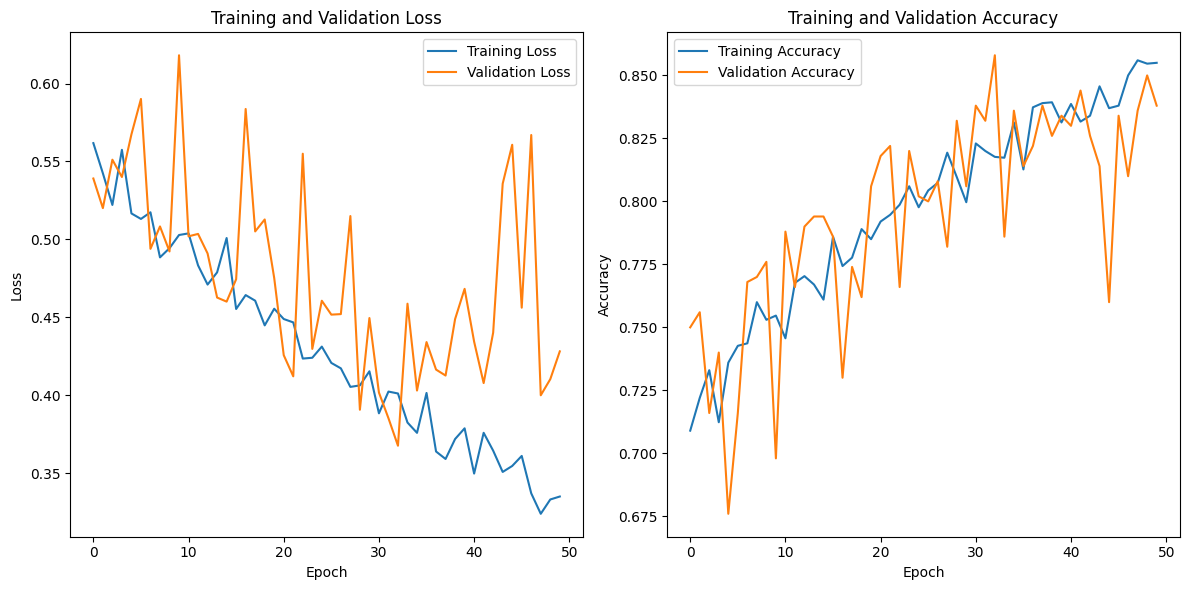

In [ ]:
import matplotlib.pyplot as plt

# Extract the training and validation loss and accuracy from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate the model on the test data
evaluation = model.evaluate(test_generator)

# Print the evaluation results
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

5/5 [==============================] - 1s 169ms/step - loss: 0.3399 - acc: 0.8520
Test Loss: 0.33986952900886536
Test Accuracy: 0.8519999980926514


In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
TRAIN_DIR = "/content/train"
TEST_DIR = "/content/test1"

TOTAL_TRAIN_SIZE = 15000
VALID_SIZE = 2000
TEST_SIZE = 2000

BATCH_SIZE = 100
EPOCHS = 50

IMAGE_WIDTH = IMAGE_HEIGHT = 150

# creating df with train labels
train_filenames = os.listdir(TRAIN_DIR)
train_labels = [filename.split('.')[0] for filename in train_filenames]

train_df = pd.DataFrame({
    'id': train_filenames,
    'label': train_labels
})

# Shuffle the DataFrame
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into train, validation, and test sets
train_set = train_df[:TOTAL_TRAIN_SIZE]
remaining_set = train_df[TOTAL_TRAIN_SIZE:]

valid_set = remaining_set[:VALID_SIZE]
test_set = remaining_set[VALID_SIZE:VALID_SIZE+TEST_SIZE]

# augmentation settings, for now just normalizing
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255.,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# not doing any data augmentation on validation and test set
valid_test_datagen = ImageDataGenerator(rescale=1./255.)

# creating train, validation, and test generators
train_generator = train_datagen.flow_from_dataframe(
    train_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    valid_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_generator = valid_test_datagen.flow_from_dataframe(
    test_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 15000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

IMAGE_WIDTH = 150
IMAGE_HEIGHT = 150
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_42 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 17, 17, 128)     

In [ ]:
history = model.fit_generator(train_generator,
                              validation_data=valid_generator,
                              steps_per_epoch=len(train_generator),
                              validation_steps=len(valid_generator),
                              epochs=EPOCHS,
                              verbose=1)

<ipython-input-49-c516ba2fb733>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/50
150/150 [==============================] - 122s 804ms/step - loss: 0.6925 - acc: 0.5412 - val_loss: 0.6789 - val_acc: 0.5415
Epoch 2/50
150/150 [==============================] - 120s 798ms/step - loss: 0.6535 - acc: 0.6117 - val_loss: 0.6024 - val_acc: 0.6830
Epoch 3/50
150/150 [==============================] - 117s 784ms/step - loss: 0.6197 - acc: 0.6515 - val_loss: 0.6310 - val_acc: 0.6305
Epoch 4/50
150/150 [==============================] - 117s 777ms/step - loss: 0.5986 - acc: 0.6736 - val_loss: 0.5666 - val_acc: 0.6955
Epoch 5/50
150/150 [==============================] - 120s 797ms/step - loss: 0.5751 - acc: 0.6874 - val_loss: 0.5171 - val_acc: 0.7540
Epoch 6/50
150/150 [==============================] - 118s 784ms/step - loss: 0.5592 - acc: 0.7081 - val_loss: 0.4742 - val_acc: 0.7810
Epoch 7/50
150/150 [==============================] - 117s 778ms/step - loss: 0.5376 - acc: 0.7289 - val_loss: 0.4734 - val_acc: 0.7720
Epoch 8/50
150/150 [============================

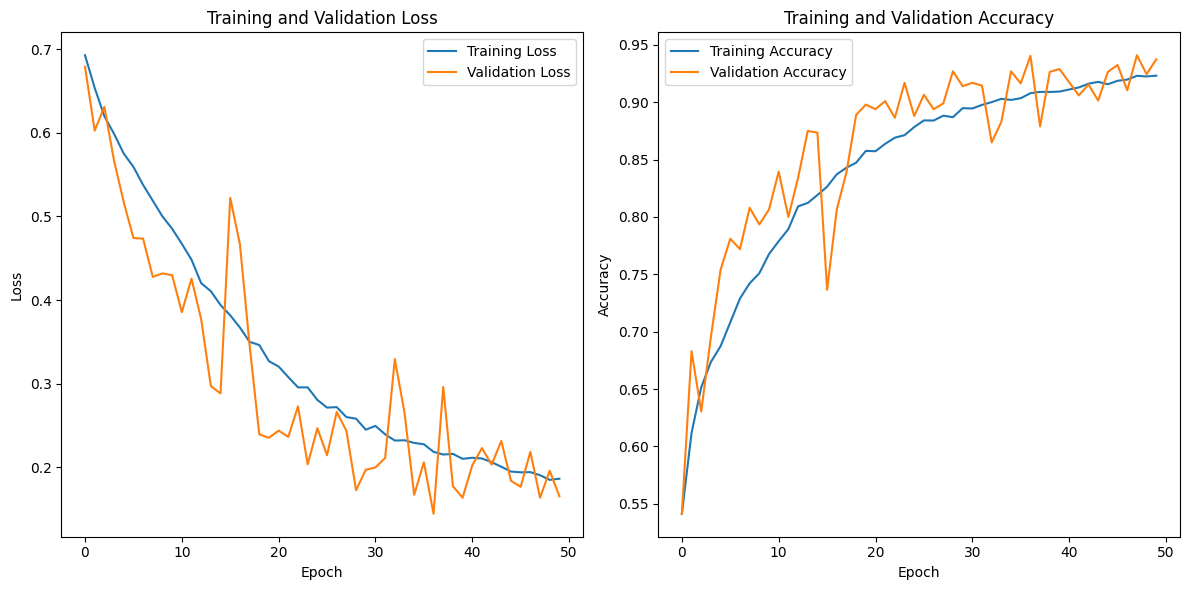

In [ ]:
import matplotlib.pyplot as plt

# Extract the training and validation loss and accuracy from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate the model on the test data
evaluation = model.evaluate(test_generator)

# Print the evaluation results
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

20/20 [==============================] - 4s 212ms/step - loss: 0.1667 - acc: 0.9285
Test Loss: 0.16666041314601898
Test Accuracy: 0.9284999966621399


In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
TRAIN_DIR = "/content/train"
TEST_DIR = "/content/test1"

TOTAL_TRAIN_SIZE = 1000
VALID_SIZE = 500
TEST_SIZE = 500

BATCH_SIZE = 32
EPOCHS = 50

IMAGE_WIDTH = IMAGE_HEIGHT = 224

# creating df with train labels
train_filenames = os.listdir(TRAIN_DIR)
train_labels = [filename.split('.')[0] for filename in train_filenames]

train_df = pd.DataFrame({
    'id': train_filenames,
    'label': train_labels
})

# Shuffle the DataFrame
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into train, validation, and test sets
train_set = train_df[:TOTAL_TRAIN_SIZE]
remaining_set = train_df[TOTAL_TRAIN_SIZE:]

valid_set = remaining_set[:VALID_SIZE]
test_set = remaining_set[VALID_SIZE:VALID_SIZE+TEST_SIZE]
# augmentation settings, for now just normalizing
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255.,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# not doing any data augmentation on validation and test set
valid_test_datagen = ImageDataGenerator(rescale=1./255.)

# creating train, validation, and test generators
train_generator = train_datagen.flow_from_dataframe(
    train_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    valid_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_generator = valid_test_datagen.flow_from_dataframe(
    test_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 1000 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [ ]:
g_dict = train_generator.class_indices
classes = list(g_dict.keys())
images, labels = next(train_generator)
num_samples = len(images)


In [ ]:
from keras.applications import MobileNetV2
from keras.models import Sequential
from keras.layers import Dense, Flatten

# Load the MobileNetV2 model pretrained on ImageNet data
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

# Freeze the convolutional layers to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pretrained base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary of the model architecture
model.summary()

# Train the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=valid_generator,
    validation_steps=len(valid_generator)
)


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_13 (Flatten)        (None, 62720)             0         
                                                                 
 dense_28 (Dense)            (None, 256)               16056576  
                                                                 
 dense_29 (Dense)            (None, 1)                 257       
                                                                 
Total params: 18314817 (69.87 MB)
Trainable params: 16056833 (61.25 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


<ipython-input-70-072d65f0da25>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
32/32 [==============================] - 22s 537ms/step - loss: 2.7538 - accuracy: 0.8930 - val_loss: 0.9429 - val_accuracy: 0.9760
Epoch 2/50
32/32 [==============================] - 15s 456ms/step - loss: 0.6194 - accuracy: 0.9620 - val_loss: 0.9080 - val_accuracy: 0.9700
Epoch 3/50
32/32 [==============================] - 18s 574ms/step - loss: 0.9738 - accuracy: 0.9500 - val_loss: 0.9670 - val_accuracy: 0.9720
Epoch 4/50
32/32 [==============================] - 27s 865ms/step - loss: 0.3147 - accuracy: 0.9750 - val_loss: 1.3323 - val_accuracy: 0.9700
Epoch 5/50
32/32 [==============================] - 17s 519ms/step - loss: 0.7991 - accuracy: 0.9640 - val_loss: 0.5158 - val_accuracy: 0.9700
Epoch 6/50
32/32 [==============================] - 17s 548ms/step - loss: 0.4229 - accuracy: 0.9700 - val_loss: 0.5261 - val_accuracy: 0.9740
Epoch 7/50
32/32 [==============================] - 17s 542ms/step - loss: 0.3833 - accuracy: 0.9710 - val_loss: 0.6364 - val_accuracy: 0.9740

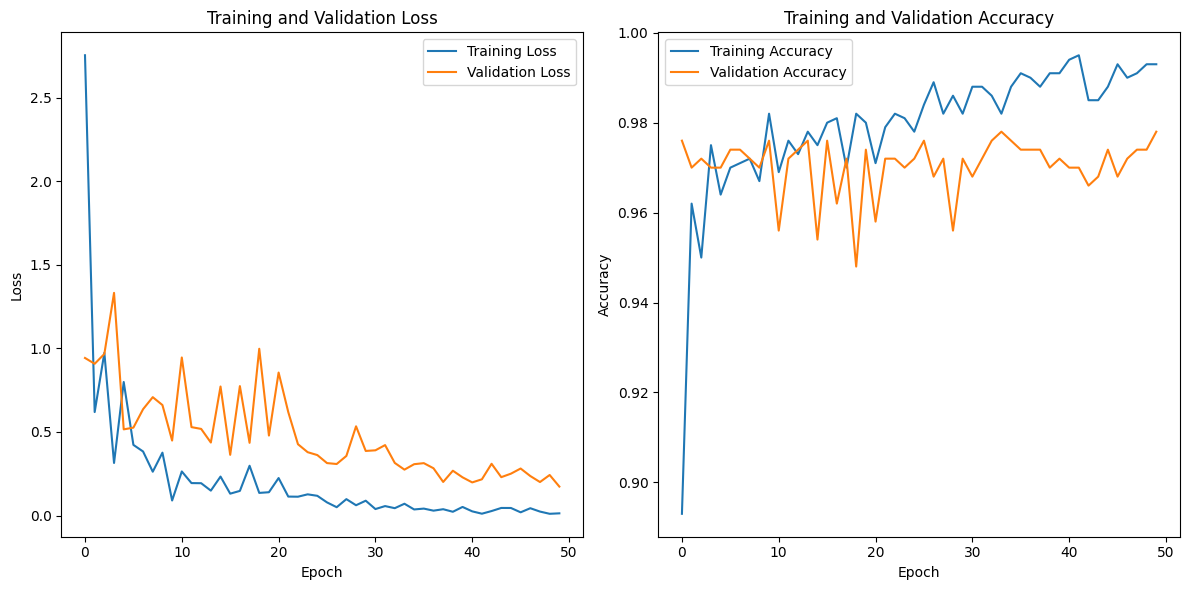

In [ ]:
import matplotlib.pyplot as plt

# Extract the training and validation loss and accuracy from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate_generator(test_generator, steps=len(test_generator))
print('Test accuracy:', test_acc)

<ipython-input-73-ce17c81db7c4>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator, steps=len(test_generator))


Test accuracy: 0.9760000109672546


In [74]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
TRAIN_DIR = "/content/train"
TEST_DIR = "/content/test1"

TOTAL_TRAIN_SIZE = 3000
VALID_SIZE = 500
TEST_SIZE = 500

BATCH_SIZE = 32
EPOCHS = 50

IMAGE_WIDTH = IMAGE_HEIGHT = 224

# creating df with train labels
train_filenames = os.listdir(TRAIN_DIR)
train_labels = [filename.split('.')[0] for filename in train_filenames]

train_df = pd.DataFrame({
    'id': train_filenames,
    'label': train_labels
})

# Shuffle the DataFrame
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into train, validation, and test sets
train_set = train_df[:TOTAL_TRAIN_SIZE]
remaining_set = train_df[TOTAL_TRAIN_SIZE:]

valid_set = remaining_set[:VALID_SIZE]
test_set = remaining_set[VALID_SIZE:VALID_SIZE+TEST_SIZE]
# augmentation settings, for now just normalizing
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255.,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# not doing any data augmentation on validation and test set
valid_test_datagen = ImageDataGenerator(rescale=1./255.)

# creating train, validation, and test generators
train_generator = train_datagen.flow_from_dataframe(
    train_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    valid_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_generator = valid_test_datagen.flow_from_dataframe(
    test_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)
# Train the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=valid_generator,
    validation_steps=len(valid_generator)
)


Found 3000 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


<ipython-input-74-820b15a8507d>:79: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
94/94 [==============================] - 56s 599ms/step - loss: 0.1220 - accuracy: 0.9627 - val_loss: 0.1165 - val_accuracy: 0.9720
Epoch 2/50
94/94 [==============================] - 50s 527ms/step - loss: 0.0762 - accuracy: 0.9697 - val_loss: 0.1234 - val_accuracy: 0.9700
Epoch 3/50
94/94 [==============================] - 45s 483ms/step - loss: 0.0696 - accuracy: 0.9733 - val_loss: 0.1242 - val_accuracy: 0.9720
Epoch 4/50
94/94 [==============================] - 47s 501ms/step - loss: 0.0731 - accuracy: 0.9723 - val_loss: 0.1047 - val_accuracy: 0.9740
Epoch 5/50
94/94 [==============================] - 49s 516ms/step - loss: 0.0560 - accuracy: 0.9780 - val_loss: 0.1373 - val_accuracy: 0.9700
Epoch 6/50
94/94 [==============================] - 45s 479ms/step - loss: 0.0558 - accuracy: 0.9770 - val_loss: 0.1409 - val_accuracy: 0.9660
Epoch 7/50
94/94 [==============================] - 47s 497ms/step - loss: 0.0667 - accuracy: 0.9760 - val_loss: 0.1243 - val_accuracy: 0.9660

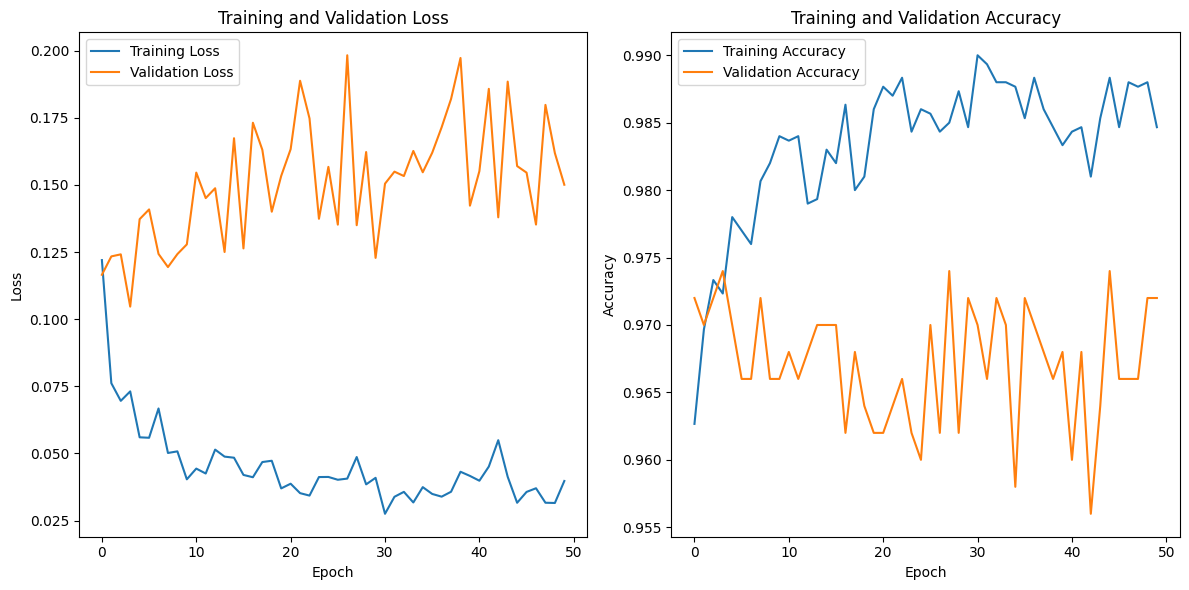

In [75]:
import matplotlib.pyplot as plt

# Extract the training and validation loss and accuracy from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [76]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate_generator(test_generator, steps=len(test_generator))
print('Test accuracy:', test_acc)

<ipython-input-76-ce17c81db7c4>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator, steps=len(test_generator))


Test accuracy: 0.9819999933242798
